# Digits Variational Autoencoder

In [1]:
pip install emnist

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint

from emnist import list_datasets, extract_training_samples

In [3]:
if False: # only for JupyterLab with GPUs environment
    import sys
    sys.path.insert(0, '/notebooks/')
    sys.path.insert(0, '../')
    from CapsuleLib.utils import gpu_config
    gpuid = gpu_config(False, True)

## Hyperparameter setting

In [4]:
TRAINING = False
BATCH_SIZE = 64
EPOCHS = 10
IM_SIZE = 28
LATENT_SPACE_DIM = 5

## Data preparation

In [5]:
# Load MNIST digits
x_digits, _ = extract_training_samples('digits')
x_digits = x_digits.astype("float32") / 255.0
x_digits = np.reshape(x_digits, (*x_digits.shape, 1))

# Load EMNIST letters
x_letters, y_letters = extract_training_samples('letters')
x_letters = x_letters[(y_letters!=12)&(y_letters!=15)&(y_letters!=9)] # exclude I, l and O 
x_letters = x_letters.astype("float32") / 255.0
x_letters = np.reshape(x_letters, (*x_letters.shape, 1)) 

# Train-test split
x_train, x_val = train_test_split(x_digits, test_size=0.2, random_state=0)

# Data generator
datagen = ImageDataGenerator(
    rotation_range = 5,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    fill_mode = "nearest"
)

<ipython-input-6-f2fbe2fc76f4>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


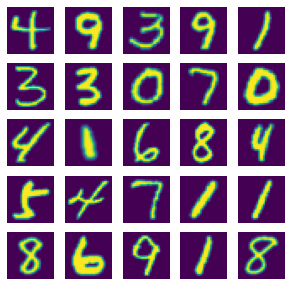

In [6]:
# Sample some images
N = 5
fig, ax = plt.subplots(N,N, figsize=(N,N))
for i in range(N**2):
    ax[i%N,i//N].imshow(x_train[i])
    ax[i%N,i//N].axis('off')
fig.show()

## VAE model

In [7]:
def loss_func(encoder_mu, encoder_log_variance):
    
    def vae_reconstruction_loss(y_true, y_predict):
        
        reconstruction_loss_factor = IM_SIZE*IM_SIZE*2
        reconstruction_loss = keras.backend.mean(keras.backend.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        
        kl_loss = -0.5 * keras.backend.sum(1.0 + encoder_log_variance - keras.backend.square(encoder_mu) - keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)
        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

In [8]:
if TRAINING:
    x = keras.layers.Input(shape=(IM_SIZE, IM_SIZE, 1), name="encoder_input")

    encoder_conv_layer1 = keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(x)
    encoder_norm_layer1 = keras.layers.BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
    encoder_activ_layer1 = keras.layers.ReLU(name="encoder_ReLu_1")(encoder_norm_layer1)

    encoder_conv_layer2 = keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_2")(encoder_activ_layer1)
    encoder_norm_layer2 = keras.layers.BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
    encoder_activ_layer2 = keras.layers.ReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

    encoder_conv_layer3 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_3")(encoder_activ_layer2)
    encoder_norm_layer3 = keras.layers.BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
    encoder_activ_layer3 = keras.layers.ReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

    shape_before_flatten = keras.backend.int_shape(encoder_activ_layer3)[1:]
    encoder_flatten = keras.layers.Flatten()(encoder_activ_layer3)

    encoder_mu = keras.layers.Dense(units=LATENT_SPACE_DIM, name="encoder_mu")(encoder_flatten)
    encoder_log_variance = keras.layers.Dense(units=LATENT_SPACE_DIM, name="encoder_log_variance")(encoder_flatten)

    def sampling(mu_log_variance): 
        mu, log_variance = mu_log_variance
        epsilon = keras.backend.random_normal(shape=keras.backend.shape(mu), mean=0.0, stddev=1.0)
        random_sample = mu + keras.backend.exp(log_variance/2) * epsilon
        return random_sample
    encoder_output = keras.layers.Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])

    encoder =  keras.models.Model(x, encoder_output, name="encoder_model")

    decoder_input = keras.layers.Input(shape=(LATENT_SPACE_DIM), name="decoder_input")
    decoder_dense_layer1 = keras.layers.Dense(units=np.prod(shape_before_flatten), name="decoder_dense_1")(decoder_input)
    decoder_reshape = keras.layers.Reshape(target_shape=shape_before_flatten)(decoder_dense_layer1)

    decoder_conv_tran_layer1 = keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
    decoder_norm_layer1 = keras.layers.BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
    decoder_activ_layer1 = keras.layers.ReLU(name="decoder_ReLu_1")(decoder_norm_layer1)

    decoder_conv_tran_layer2 = keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_2")(decoder_activ_layer1)
    decoder_norm_layer2 = keras.layers.BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
    decoder_activ_layer2 = keras.layers.ReLU(name="decoder_ReLu_2")(decoder_norm_layer2)

    decoder_conv_tran_layer3 = keras.layers.Conv2DTranspose(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_3")(decoder_activ_layer2)
    decoder_output = keras.layers.ReLU(name="decoder_output")(decoder_conv_tran_layer3)

    decoder = keras.models.Model(decoder_input, decoder_output, name="decoder_model")

    vae_input = keras.layers.Input(shape=(IM_SIZE, IM_SIZE, 1), name="VAE_input")
    vae_encoder_output = encoder(vae_input)
    vae_decoder_output = decoder(vae_encoder_output)
    vae = keras.models.Model(vae_input, vae_decoder_output, name="VAE")

else:
    vae = keras.models.load_model('models/mnist-vae.h5', compile=False)
    encoder = keras.models.load_model("models/mnist-encoder.h5", compile=False)
    decoder = keras.models.load_model("models/mnist-decoder.h5", compile=False)
    
vae.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VAE_input (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_model (Functional)   (None, 5)                 144664    
_________________________________________________________________
decoder_model (Functional)   (None, 28, 28, 1)         150209    
Total params: 294,873
Trainable params: 294,423
Non-trainable params: 450
_________________________________________________________________


reconstruction loss + KL divergence (https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-understanding-kl-divergence-2b382ca2b2a8)

In [9]:
if TRAINING:

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='auto', factor=0.2, verbose=1, patience=3, min_lr=0.00001)
    vae.compile(optimizer=keras.optimizers.Adam(lr=0.0005), loss=loss_func(encoder_mu, encoder_log_variance))
    
    vae.fit(datagen.flow(x_train, x_train, batch_size=BATCH_SIZE), epochs=EPOCHS, shuffle=True, validation_data=(x_val, x_val), callbacks=[reduce_lr])

### Model evaluation

In [10]:
def plot_reconstructions(x_sample):
    
    decoded_sample = vae.predict(x_sample)

    N=10
    fig, ax = plt.subplots(3,N, figsize=(N,3))
    for i in range(N):
        ax[0,i].imshow(x_sample[i])
        ax[0,i].axis('off')
        ax[1,i].imshow(decoded_sample[i])
        ax[1,i].axis('off')
        ax[2,i].imshow(np.abs(x_sample[i]-decoded_sample[i]), cmap="binary")
        ax[2,i].axis('off')
    fig.tight_layout()
    
def vae_reconstruction_loss(y_true, y_predict):
    reconstruction_loss_factor = IM_SIZE*IM_SIZE*2
    reconstruction_loss = keras.backend.mean(keras.backend.square(y_true-y_predict))
    return reconstruction_loss_factor * reconstruction_loss

def plot_hist():
    digit_losses, letter_losses = [], []
    decoded_digits = vae.predict(x_val)
    for i in range(x_val.shape[0]//10):
        image = x_val[i]
        decoded_image = decoded_digits[i]
        decoded_image = decoded_image/decoded_image.max()
        digit_losses.append(float(vae_reconstruction_loss(image, decoded_image)))

    decoded_letters = vae.predict(x_letters)
    for i in range(x_val.shape[0]//10):
        image = x_letters[i]
        decoded_image = decoded_letters[i]
        decoded_image = decoded_image/decoded_image.max()
        letter_losses.append(float(vae_reconstruction_loss(image, decoded_image)))

    fig, ax = plt.subplots(figsize=(6,6))
    ax.hist(digit_losses, bins=50, alpha=0.4, label="digits (IN)", color="blue")
    ax.hist(letter_losses, bins=50, alpha=0.5, label="letter (OOD)", color="orange")
    #ax.axvline(x=BOUNDARY, color='r')
    plt.xlabel("Reconstruction error")
    plt.legend()
    plt.title("Error histograms")
    plt.yticks([])
    fig.show()

def plot_roc(x_original, x_reconstructed, y_true, 
                   boundary_range=np.concatenate([np.linspace(0,70,100), np.linspace(80,300,50)])):
    
    roc_values = []
    
    for boundary in boundary_range:
        
        y_pred = []

        for i in range(x_original.shape[0]):
            image = x_original[i]
            reconstructed_image = x_reconstructed[i]
            reconstructed_image = reconstructed_image/reconstructed_image.max()
            if float(vae_reconstruction_loss(image, reconstructed_image)) > boundary:
                y_pred.append(1)
            else:
                y_pred.append(0)

        y_pred=np.array(y_pred)
        
        sensitivity = np.sum(np.logical_and(y_pred,y_true))/np.sum(y_true)
        specificity = np.sum(~np.logical_or(y_pred,y_true)/(y_pred.size-np.sum(y_true)))
                             
        roc_values.append((1-specificity, sensitivity))
                             
    plt.step(*list(zip(*roc_values)), where='post', label='VAE classifier v1')
    plt.xlabel("1 - specificity")
    plt.ylabel("sensitivity")
    plt.plot([0,1], [0,1], '--', color="gray", label='random', linewidth=2)
    plt.legend()
    plt.title("ROC curve")

### Reconstructions

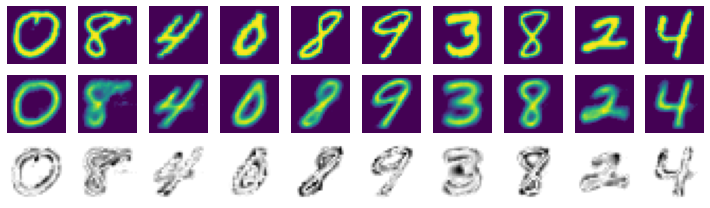

In [11]:
sample = np.random.choice(x_val.shape[0], 10)
plot_reconstructions(x_val[sample])
plt.savefig('results/digits-reconstruction.png')

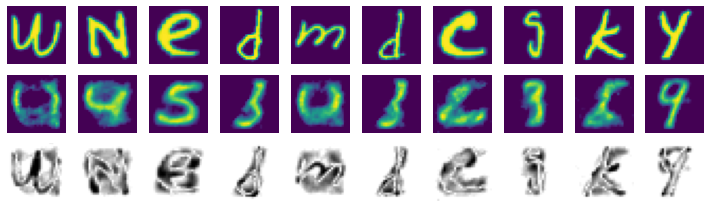

In [12]:
letters_sample = np.random.choice(x_val.shape[0], 10)
plot_reconstructions(x_letters[letters_sample])
plt.savefig('results/letters-reconstruction.png')

## OOD

<ipython-input-10-c747a0f7c6e1>:45: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


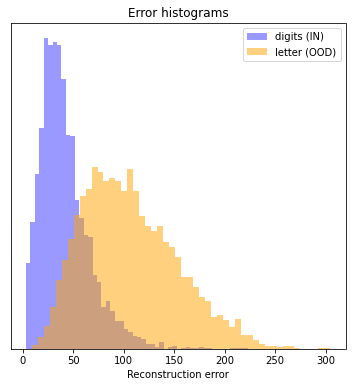

In [13]:
plot_hist()
plt.savefig('results/mnist-vae-hist.png')

In [14]:
x_test = np.concatenate([x_val, x_letters])
y_test = np.concatenate([np.zeros(x_val.shape[0]),np.ones(x_letters.shape[0])])

idx_sample = np.random.choice(x_test.shape[0], 1000)
x_test_sample = x_test[idx_sample]
y_test_sample = y_test[idx_sample]

decoded_data = vae.predict(x_test_sample)

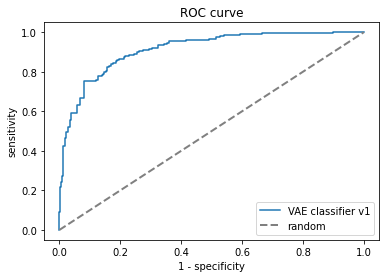

In [15]:
plot_roc(x_test_sample, decoded_data, y_test_sample)
plt.savefig('results/vae-roc.png')

## Qualitative analysis

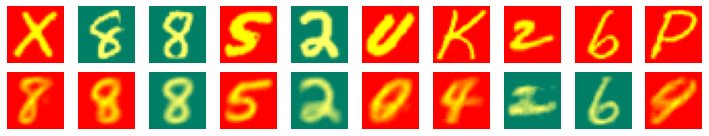

In [16]:
N=10
BOUNDARY = 60
idx_sample = np.random.choice(x_test.shape[0], N)
x_test_sample = x_test[idx_sample]
y_test_sample = y_test[idx_sample]

encoded_sample = encoder.predict(x_test_sample)
decoded_sample = decoder.predict(encoded_sample)

fig, ax = plt.subplots(2,N, figsize=(N,2))
for i in range(N):
    image = x_test_sample[i]
    reconstructed_image = decoded_sample[i]
    diff = vae_reconstruction_loss(image, reconstructed_image)
    
    if y_test_sample[i]==1:
        cmap1 = "autumn"
    else:
        cmap1 = "summer"
    ax[0,i].imshow(image, cmap=cmap1)
    ax[0,i].axis('off')
    
    if diff>BOUNDARY:
        cmap2 = "autumn"
    else:
        cmap2 = "summer"
    ax[1,i].imshow(reconstructed_image, cmap=cmap2)
    ax[1,i].axis('off')
    
fig.tight_layout()
plt.savefig('results/vae-ood.png')